In [1]:
# %matplotlib notebook

## Setting Environment
### Get all imports

In [2]:
import pickle

# linear algebra
import numpy as np
# data processing
import pandas as pd
# data visualization
import seaborn as sns
import time
from matplotlib import pyplot as plt
# Algorithms
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

### Load the train and test dataset

In [3]:
test_df = pd.read_csv("./data/test.csv")
train_df = pd.read_csv("./data/train.csv")

print(f"Loaded train data set with shape:{train_df.shape}")
print(f"Loaded test data set with shape:{test_df.shape}")

Loaded train data set with shape:(891, 12)
Loaded test data set with shape:(418, 11)


## Exploration

### Find missing data in all columns

In [4]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum() / train_df.isnull().count() * 100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])

print(f"Columns with missing data:\n{missing_data.head(5)}")

Columns with missing data:
             Total     %
Cabin          687  77.1
Age            177  19.9
Embarked         2   0.2
PassengerId      0   0.0
Survived         0   0.0


## Understanding survival wrt: *Gender* and *Age*

/opt/miniconda3/envs/titanic/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


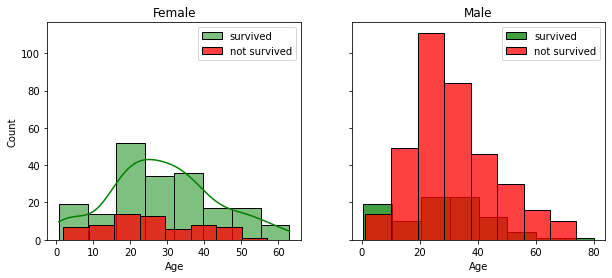

In [5]:
survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey='all')

train_df['age_bucket'] = pd.qcut(train_df['Age'],
                                 q=10,
                                 labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                 precision=0
                                 )

women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']

ax = sns.histplot(women[women['Survived'] == 1].Age.dropna(), bins=8, label=survived, ax=axes[0], kde=True,
                  color='green')
ax = sns.histplot(women[women['Survived'] == 0].Age.dropna(), bins=8, label=not_survived, ax=axes[0], kde=False,
                  color='red')

ax.legend()
ax.set_title('Female')
ax = sns.histplot(men[men['Survived'] == 1].Age.dropna(), bins=8, label=survived, ax=axes[1], kde=False, color='green')
ax = sns.histplot(men[men['Survived'] == 0].Age.dropna(), bins=8, label=not_survived, ax=axes[1], kde=False,
                  color='red')
ax.legend()
_ = ax.set_title('Male')

fig.show()

## Understanding survival wrt:  *PClass, Embarked*

/opt/miniconda3/envs/titanic/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
/opt/miniconda3/envs/titanic/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/opt/miniconda3/envs/titanic/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


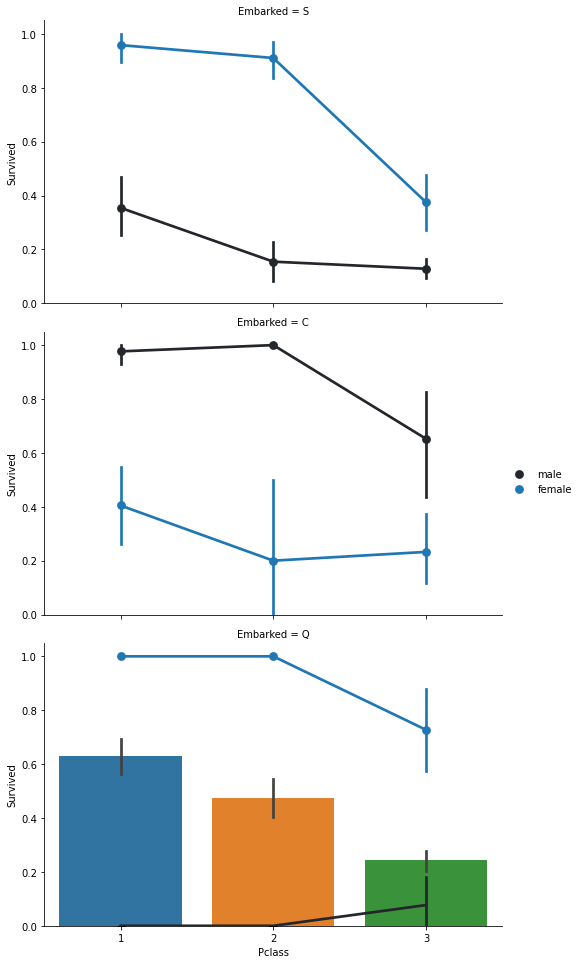

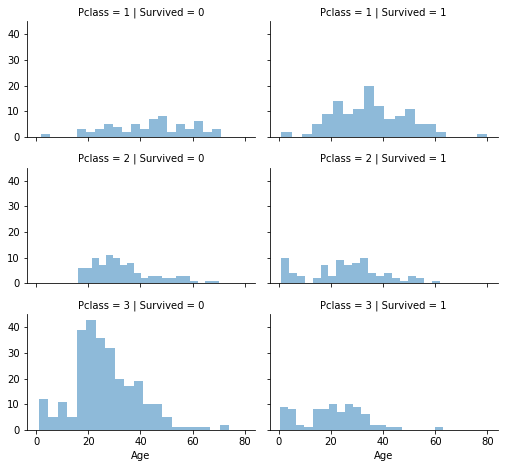

In [6]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None, order=None, hue_order=None)
FacetGrid.add_legend()
FacetGrid.fig.show()

sns.barplot(x='Pclass', y='Survived', data=train_df).figure.show()


grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()
grid.fig.show()

## create "not_alone" feature

In [7]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

<AxesSubplot:title={'center':'Survival wrt family size'}, xlabel='relatives'>

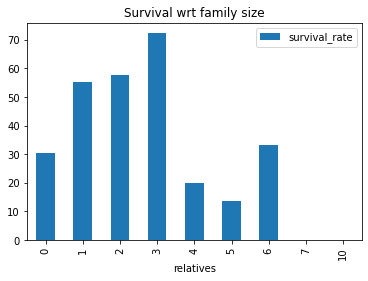

In [8]:
gdf = train_df.groupby('relatives').agg({'Survived': ['count', 'sum']})

gdf.columns = ['-'.join(col) for col in gdf.columns]
gdf = gdf.rename(columns={'Survived-count': 'total',
                      'Survived-sum': 'survived'})

gdf['survival_rate'] = gdf.survived/gdf.total*100
gdf = gdf.drop(['total','survived'], axis=1)
gdf.plot(y='survival_rate', kind ='bar', title='Survival wrt family size')

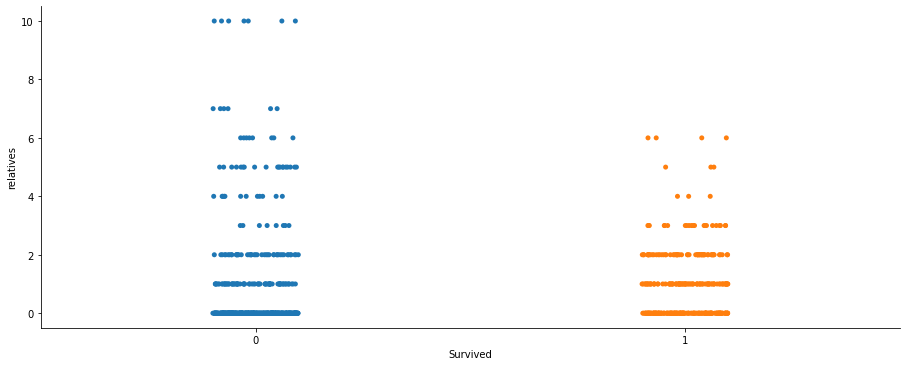

In [9]:
axes = sns.catplot(x='Survived', y='relatives',
                   data=train_df, aspect=2.5, hue='Survived' )

### drop passengerId column as it is not adding any information

In [10]:
train_df = train_df.drop(['PassengerId'], axis=1)

### convert Cabin feature to Deck feature by string manipulation

In [11]:
import re

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)


### imputate Age column by filling missing values

In [12]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

print(train_df["Age"].isnull().sum())

0


## fill Embarked with the most common value of 'S' (Imputate Embarked column)

In [13]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)


## Imputate *Fare* column

In [14]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)


## Imputate Name column and change it to Title

In [15]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', \
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)

train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

## Imputate *Sex* column

In [16]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

## since Ticket is not informative, we'll drop it

In [17]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)


## imputate Embarked column

In [18]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Categorise Age column in bins

In [19]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed
print(train_df['Age'].value_counts())


The current time is: 2021-03-03 17:14:31
4    166
6    157
5    153
3    139
2    115
1     93
0     68
Name: Age, dtype: int64


## Categorise Fare column

In [20]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare'] = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare'] = 4
    dataset.loc[dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

## adding new features - age times class, fare per person

In [21]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare'] / (dataset['relatives'] + 1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

## Drop Survived, PassengerId and age_bucket column

In [22]:
X_train = train_df.drop(["Survived", "age_bucket"], axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()

## Trying different algorithms
#### 1. SGD

In [23]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

#### 2. Random Forest

In [24]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

#### 3. Logistic Regression

In [25]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

/opt/miniconda3/envs/titanic/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### 4. KNN algorithm

In [26]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

#### 5. Gaussian Naive Bayes

In [27]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

#### 6. Perceptron

In [28]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

/opt/miniconda3/envs/titanic/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


#### 7. Linear SVM

In [29]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

/opt/miniconda3/envs/titanic/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### 8. Decision Trees

In [30]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

#### which is the best model?

In [31]:
import time
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")

results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent',
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log,
              acc_random_forest, acc_gaussian, acc_perceptron,
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')

print(result_df.head(n=10))

The current time is: 2021-03-03 17:14:31
                            Model
Score                            
92.59               Random Forest
92.59               Decision Tree
87.65                         KNN
81.59         Logistic Regression
81.03     Support Vector Machines
80.58                  Perceptron
77.10                 Naive Bayes
74.30  Stochastic Gradient Decent


#### K Fold cross validation

In [32]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
rf = RandomForestClassifier(n_estimators=100)
# TODO: scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring="accuracy")
scores = pickle.load(open('./data/scores.pkl', 'rb'))

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


The current time is: 2021-03-03 17:14:31
Scores: [0.75555556 0.79775281 0.74157303 0.84269663 0.86516854 0.84269663
 0.85393258 0.76404494 0.83146067 0.85393258]
Mean: 0.8148813982521848
Standard Deviation: 0.04378634369949139


## Plotting Feature Importances

The current time is: 2021-03-03 17:14:31


<AxesSubplot:xlabel='feature'>

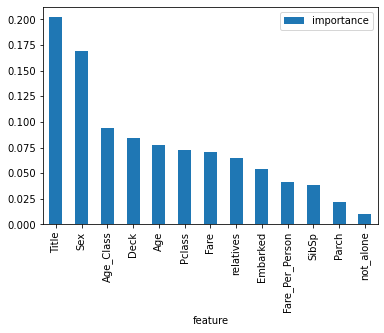

In [33]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
importances.head(15)

importances.plot.bar()

## Remove unimportand features

In [34]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
train_df = train_df.drop("not_alone", axis=1)
test_df = test_df.drop("not_alone", axis=1)

train_df = train_df.drop("Parch", axis=1)
test_df = test_df.drop("Parch", axis=1)

The current time is: 2021-03-03 17:14:31


##  retrain random forest after removing unimportant columns - (not_alone, Parch)

In [35]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
random_forest = RandomForestClassifier(n_estimators=100, oob_score=True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest, 2, ), "%")


The current time is: 2021-03-03 17:14:31
92.59 %


## OOB Score - Out of Bag score

In [36]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print("oob score:", round(random_forest.oob_score_, 4) * 100, "%")

The current time is: 2021-03-03 17:14:32
oob score: 82.15 %


## Hyperparameter tuning

In [37]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
param_grid = {"criterion": ["gini", "entropy"], "min_samples_leaf": [1, 5, 10, 25, 50, 70],
              "min_samples_split": [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}

# rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
# clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
# clf.fit(X_train, Y_train)
# TODO: recalculate clf.fit() when working on real data
clf = pickle.load(open('./data/clf.pkl', 'rb'))
print(clf.best_params_)


The current time is: 2021-03-03 17:14:32
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 700}


## Test new parameters - Improved OOB score?

In [38]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
random_forest = RandomForestClassifier(criterion = "entropy",
                                       min_samples_leaf = 5,
                                       min_samples_split = 16,
                                       n_estimators=700,
                                       max_features='auto',
                                       oob_score=True,
                                       random_state=1,
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")


The current time is: 2021-03-03 17:14:32
oob score: 83.16 %


##  Confusion Matrix

In [39]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
print("Confusion Matrix:",confusion_matrix(Y_train, predictions))

The current time is: 2021-03-03 17:14:33
Confusion Matrix: [[489  60]
 [ 93 249]]


## Precision-Recall

In [40]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

The current time is: 2021-03-03 17:14:37
Precision: 0.8058252427184466
Recall: 0.7280701754385965


## Calculating F-score

In [41]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

The current time is: 2021-03-03 17:14:37


0.7649769585253456

## Plotting precision and recall

The current time is: 2021-03-03 17:14:37


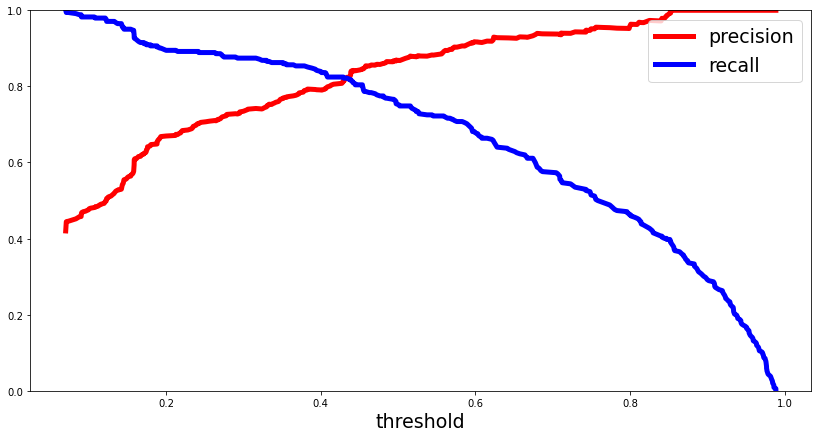

In [42]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

## ROC & AUC

The current time is: 2021-03-03 17:14:37
ROC-AUC-Score: 0.9208182873699123


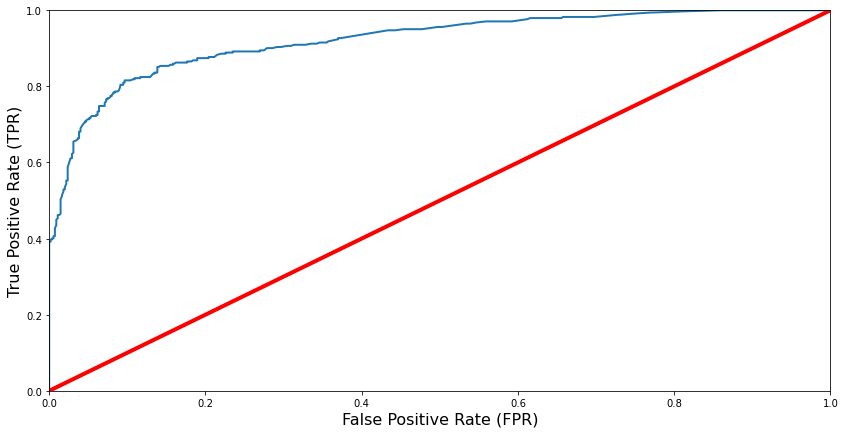

In [43]:
print (f"The current time is: {time.strftime('%Y-%m-%d %H:%M:%S')}")
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)